In [1]:
# Imports and constants
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere, circuit_drawer
from qiskit.quantum_info import hellinger_fidelity
from qiskit.result.utils import marginal_distribution

import matplotlib.pyplot as plt
import numpy as np
import math
import statistics


# Constants
backend = AerSimulator()
n = 4
shots = 20000

# Bits to Qubits
EXAMPLES
***

### Input image and corresponding angle 
For every data point $d_i \in [0, 255]$, corresponding angle $\theta_i \in [0, \theta_m]$
$$
\theta_i = \frac{d_i}{255} \times \theta_m
$$

In [2]:
# Prepare linear input array of size 'n' and get corresponding angles
def prepareInput(n=4, input_range=(0, 255), angle_range=(0, np.pi)):
    input_vector = np.linspace(start=0, stop=255, num=n, dtype=int)
    input_angles = np.interp(input_vector, input_range, angle_range) 
    
    print(f"Input Data: {input_vector}\nConverted into angles: {input_angles}")

    side = int(math.sqrt(n))

    plt.title('Input image')
    plt.imshow(np.reshape(input_vector, (side, side)), cmap='gray')
        
    return input_vector, input_angles

# Qubit Lattice Model
> _Venegas-Andraca SE, Bose S (2003)_ "Storing, processing, and retrieving an image using quantum mechanics" In: Quantum information and computation, vol 5105, pp 137–147. https://doi.org/10.1117/12.485960. International society for optics and photonics.

**Pros:**
- Simple circuit structure and constant circuit depth of 1.

**Cons:**
- Low qubit efficiency- uses 1 qubit to store 1 pixel. Therefore, the circuit width increases linearly, $n^{2}$ for an input image of size $n \times n$
- Small number of known processing methods
- Does not use quantum features like entanglement and superposition

To encode, apply the rotation gates to each qubit with appropriate angle $\theta \in [0, \pi]$.

Input Data: [  0  85 170 255]
Converted into angles: [0.         1.04719755 2.0943951  3.14159265]


┌───────┐   ░ 
q_0: ─┤ Ry(0) ├───░─
     ┌┴───────┴┐  ░ 
q_1: ┤ Ry(π/3) ├──░─
     ├─────────┴┐ ░ 
q_2: ┤ Ry(2π/3) ├─░─
     └┬───────┬─┘ ░ 
q_3: ─┤ Ry(π) ├───░─
      └───────┘   ░ 
c: 4/═══════════════

Depth: 1, Width: 4


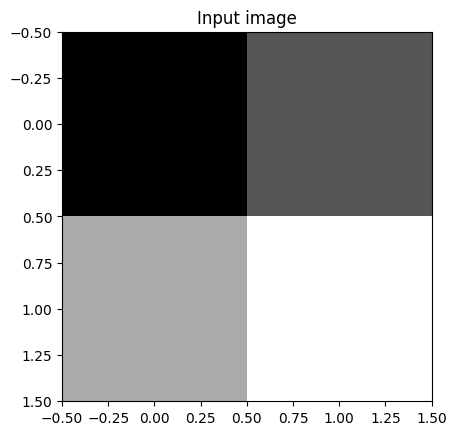

In [3]:
input_vector, input_angles = prepareInput(n=4, angle_range=(0, np.pi))

# Setup basic circuit:
ql_circuit = QuantumCircuit()

q = QuantumRegister(len(input_angles), 'q')
c = ClassicalRegister(len(input_angles), 'c')

ql_circuit.add_register(q, c)

# add Ry
for i, ang in enumerate(input_angles):
    ql_circuit.ry(ang, i)

ql_circuit.barrier()

display(ql_circuit.draw())
print(f"Depth: {ql_circuit.depth()}, Width: {ql_circuit.num_qubits}")

<IPython.core.display.Latex object>

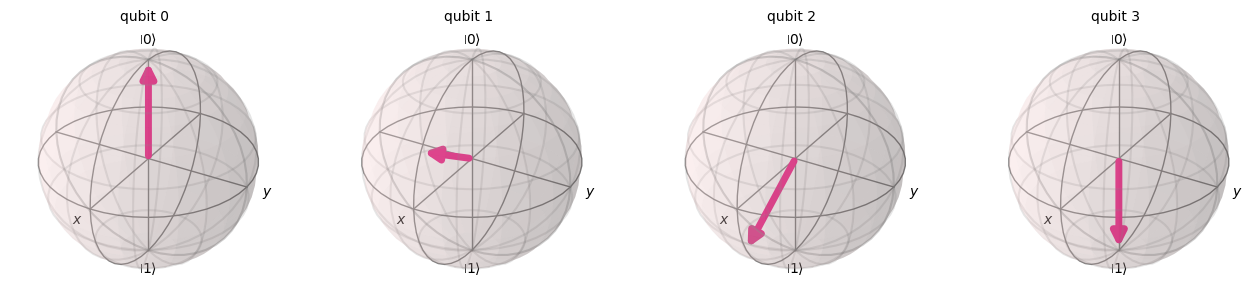

In [4]:
display(Statevector(ql_circuit).draw('latex'))

display(plot_bloch_multivector(Statevector(ql_circuit)))

In [5]:
# Simple operation of inverting the pixel values
for i in range(ql_circuit.num_qubits):
    ql_circuit.x(i)

ideal_distribution = Statevector.from_instruction(ql_circuit).probabilities_dict()

ql_circuit.barrier()

ql_circuit.measure(reversed(range(ql_circuit.num_qubits)), range(ql_circuit.num_qubits))

ql_circuit.draw()

┌───────┐   ░ ┌───┐ ░          ┌─┐
q_0: ─┤ Ry(0) ├───░─┤ X ├─░──────────┤M├
     ┌┴───────┴┐  ░ ├───┤ ░       ┌─┐└╥┘
q_1: ┤ Ry(π/3) ├──░─┤ X ├─░───────┤M├─╫─
     ├─────────┴┐ ░ ├───┤ ░    ┌─┐└╥┘ ║ 
q_2: ┤ Ry(2π/3) ├─░─┤ X ├─░────┤M├─╫──╫─
     └┬───────┬─┘ ░ ├───┤ ░ ┌─┐└╥┘ ║  ║ 
q_3: ─┤ Ry(π) ├───░─┤ X ├─░─┤M├─╫──╫──╫─
      └───────┘   ░ └───┘ ░ └╥┘ ║  ║  ║ 
c: 4/════════════════════════╩══╩══╩══╩═
                             0  1  2  3

Elapsed Time: 0.0474s
Counts: {'1000': 3658, '1100': 11420, '1010': 1275, '1110': 3647}


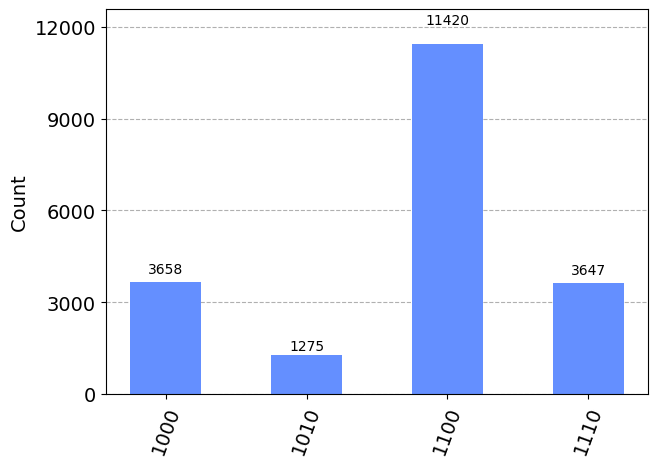

In [6]:
# Transpile and run simulation
transpiled_circuit = transpile(ql_circuit, backend=backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()


print(f"Elapsed Time: {'%.4f' % result.time_taken}s\nCounts: {counts}")
display(plot_histogram(counts))

In [7]:
big_endian_counts = {}

for key, value in counts.items():
    big_endian_counts[key[::-1]] = value

print(f"Hellinger Fidelity: {hellinger_fidelity(big_endian_counts, ideal_distribution):.3f}")

Hellinger Fidelity: 1.000


Reconstruction:
$$
output = 2 \times \arccos \left(\sqrt{P(j||Q_{p0}\rangle)}\right)
$$
where,   $P(j||Q_{p0}\rangle)$ is the conditional probability of observing a state $j$ given that the qubit $Q_{p0}$ (qubit associated with pixel $p$) is in state $|0\rangle$.

Interpolate back from (0, $\pi$) to (0, 255)

In [8]:
# DECODE
output_values = np.zeros((len(input_vector)))

for item in counts:    
    for i, bit in enumerate(item):
        if bit == '0':
            output_values[i] += counts[item]

print("Probabilities: [q0, q1, q2, q3] = ", [x/shots for x in output_values])

ql_reconstruct = [2*np.arccos((value/shots)**(1/2)) for value in output_values]

ql_reconstruct = np.interp(ql_reconstruct, (0, np.pi), (0, 255)).astype(int)

print(f"\nOriginal values: {input_vector}\nReconstructed INVERTED values: {ql_reconstruct}")

Probabilities: [q0, q1, q2, q3] =  [0.0, 0.24665, 0.7539, 1.0]

Original values: [  0  85 170 255]
Reconstructed INVERTED values: [255 170  84   0]


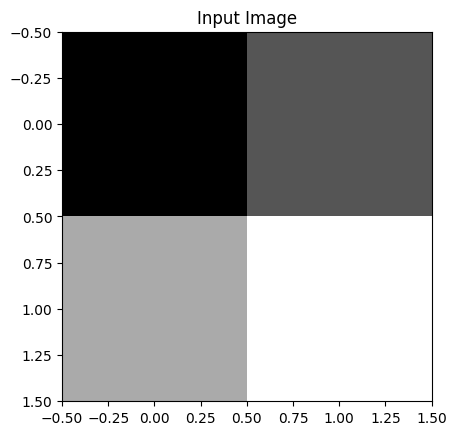

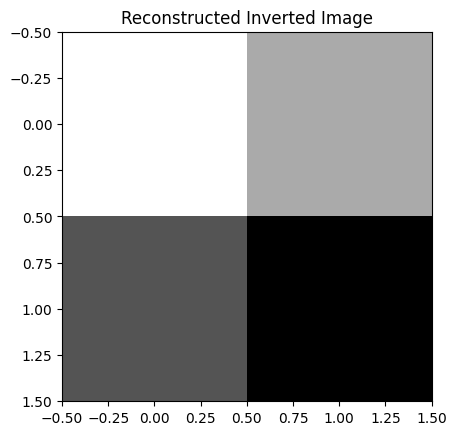

In [9]:
plt.imshow(np.reshape(input_vector, (int(math.sqrt(n)), int(math.sqrt(n)))), cmap = 'gray')
plt.title('Input Image')
plt.show()
plt.imshow(np.reshape(ql_reconstruct, (int(math.sqrt(n)), int(math.sqrt(n)))), cmap = 'gray')
plt.title('Reconstructed Inverted Image')
plt.show()

***

# Phase Encoding Algorithm

> Adapted from Dr. Jan Balewski's lecture on quantum encoding

**Pros:**
- Similar constant depth irrespective of input size
- Can be used in mulitple applications like Quantum Phase Estimation, Shor's factoring


**Cons:**
- Scalability issues, circuit width is $n^2$ for input of size $n \times n$

Uses combination of Hadamard and Phase $(H \otimes P \otimes H)$ gates to encode intensity in the phase of qubiit and see its effect as probability.

Input Data: [  0  85 170 255]
Converted into angles: [0.         1.04719755 2.0943951  3.14159265]


┌───┐  ┌──────┐  ░ 
q_0: ┤ H ├──┤ P(0) ├──░─
     ├───┤ ┌┴──────┴┐ ░ 
q_1: ┤ H ├─┤ P(π/3) ├─░─
     ├───┤┌┴────────┤ ░ 
q_2: ┤ H ├┤ P(2π/3) ├─░─
     ├───┤└─┬──────┬┘ ░ 
q_3: ┤ H ├──┤ P(π) ├──░─
     └───┘  └──────┘  ░ 
c: 4/═══════════════════

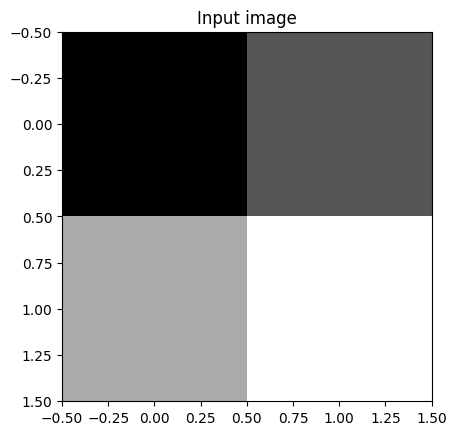

In [10]:
input_vector, input_angles = prepareInput(n=4, angle_range=(0, np.pi))

# Setup basic circuit:
ph_circuit = QuantumCircuit()

q = QuantumRegister(len(input_angles), 'q')
c = ClassicalRegister(len(input_angles), 'c')

ph_circuit.add_register(q, c)

for i, ang in enumerate(input_angles):
    ph_circuit.h(i)             # Apply Hadamard to bring qubits in superposition
    ph_circuit.p(ang, i)        # Introduce appropriate phase

ph_circuit.barrier()

ph_circuit.draw()

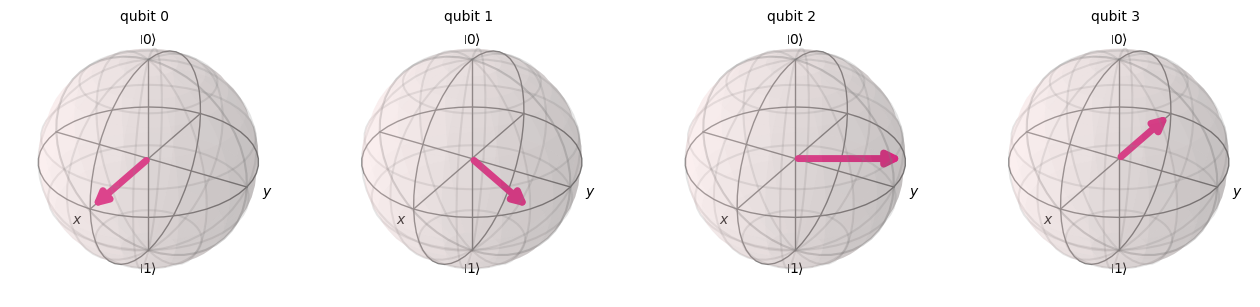

In [11]:
display(plot_bloch_multivector(Statevector(ph_circuit)))

In [12]:
for i in range(len(input_angles)):
    ph_circuit.h(i)                     # Apply Hadamard again to see the effect of phase as probability

ph_circuit.barrier()

display(ph_circuit.draw())
print(f"Depth: {ph_circuit.depth()}, Width: {ph_circuit.num_qubits}")

┌───┐  ┌──────┐  ░ ┌───┐ ░ 
q_0: ┤ H ├──┤ P(0) ├──░─┤ H ├─░─
     ├───┤ ┌┴──────┴┐ ░ ├───┤ ░ 
q_1: ┤ H ├─┤ P(π/3) ├─░─┤ H ├─░─
     ├───┤┌┴────────┤ ░ ├───┤ ░ 
q_2: ┤ H ├┤ P(2π/3) ├─░─┤ H ├─░─
     ├───┤└─┬──────┬┘ ░ ├───┤ ░ 
q_3: ┤ H ├──┤ P(π) ├──░─┤ H ├─░─
     └───┘  └──────┘  ░ └───┘ ░ 
c: 4/═══════════════════════════

Depth: 3, Width: 4


<IPython.core.display.Latex object>

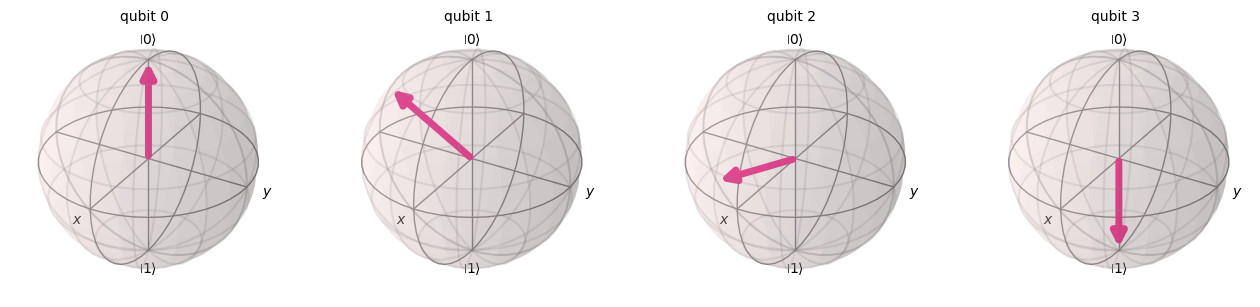

In [13]:
display(Statevector(ph_circuit).draw('latex'))

display(plot_bloch_multivector(Statevector(ph_circuit)))

In [14]:
# Simple operation of inverting the pixel values
for i in range(ph_circuit.num_qubits):
    ph_circuit.x(i)

ideal_distribution = Statevector.from_instruction(ph_circuit).probabilities_dict()

ph_circuit.barrier()

ph_circuit.measure(list(range(ph_circuit.num_qubits)), list(range(ph_circuit.cregs[0].size)))

ph_circuit.draw()

┌───┐  ┌──────┐  ░ ┌───┐ ░ ┌───┐ ░ ┌─┐         
q_0: ┤ H ├──┤ P(0) ├──░─┤ H ├─░─┤ X ├─░─┤M├─────────
     ├───┤ ┌┴──────┴┐ ░ ├───┤ ░ ├───┤ ░ └╥┘┌─┐      
q_1: ┤ H ├─┤ P(π/3) ├─░─┤ H ├─░─┤ X ├─░──╫─┤M├──────
     ├───┤┌┴────────┤ ░ ├───┤ ░ ├───┤ ░  ║ └╥┘┌─┐   
q_2: ┤ H ├┤ P(2π/3) ├─░─┤ H ├─░─┤ X ├─░──╫──╫─┤M├───
     ├───┤└─┬──────┬┘ ░ ├───┤ ░ ├───┤ ░  ║  ║ └╥┘┌─┐
q_3: ┤ H ├──┤ P(π) ├──░─┤ H ├─░─┤ X ├─░──╫──╫──╫─┤M├
     └───┘  └──────┘  ░ └───┘ ░ └───┘ ░  ║  ║  ║ └╥┘
c: 4/════════════════════════════════════╩══╩══╩══╩═
                                         0  1  2  3

Elapsed Time: 0.0521s
Counts: {'0011': 11122, '0111': 3782, '0001': 3766, '0101': 1330}


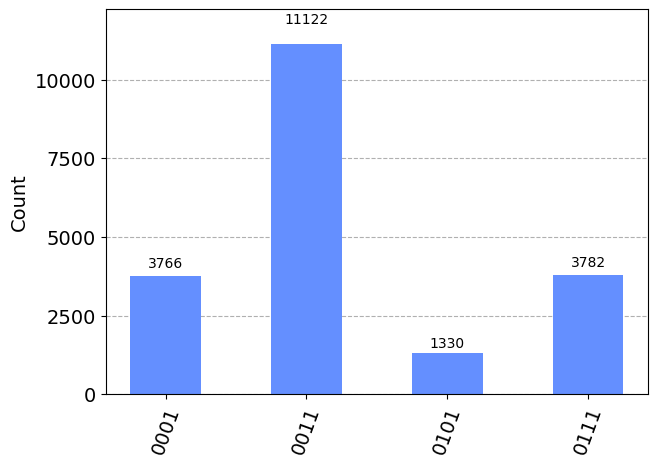

In [15]:
# Transpile and run simulation
transpiled_circuit = transpile(ph_circuit, backend=backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()


print(f"Elapsed Time: {'%.4f' % result.time_taken}s\nCounts: {counts}")
display(plot_histogram(counts))

In [16]:
print(f"Hellinger Fidelity: {hellinger_fidelity(counts, ideal_distribution):.3f}")

Hellinger Fidelity: 1.000


Classical post-processing to recover the image. Since we are measuring the effect of phase as probability, the reconstruction is similar to that of Qubit Lattice.
Here, [Qiskit's Marginal Distribution](https://github.com/Qiskit/qiskit/blob/main/qiskit/result/utils.py#L199) is used to calculate probability. 

In [17]:
ph_reconstruct = []

for  iq in range(n):
    marginal_counts = marginal_distribution(counts,[iq])
    
    if '1' in marginal_counts:
        prob = marginal_counts['1']/shots
    else:
        prob = 0
    
    ev = 1 - 2*prob

    ph_reconstruct.append(ev)

print("Probabilities: [q0, q1, q2, q3] = ", [x/shots for x in output_values])

ph_reconstruct = [np.arccos(x) for x in ph_reconstruct]

ph_reconstruct = np.interp(ph_reconstruct, (0, np.pi), (0, 255)).astype(int)

print(f"\nOriginal values: {input_vector}\nReconstructed INVERTED values: {ph_reconstruct}")

Probabilities: [q0, q1, q2, q3] =  [0.0, 0.24665, 0.7539, 1.0]

Original values: [  0  85 170 255]
Reconstructed INVERTED values: [255 169  86   0]


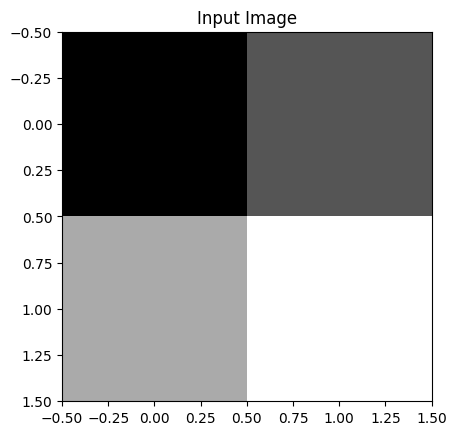

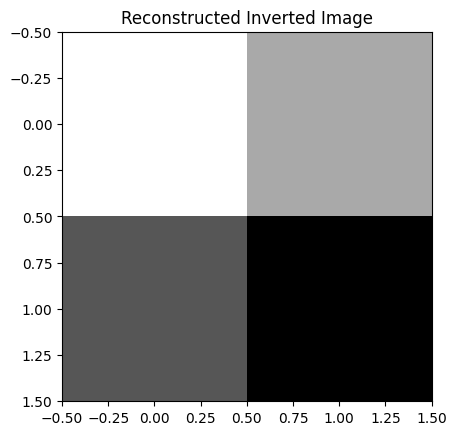

In [18]:
plt.imshow(np.reshape(input_vector, (int(math.sqrt(n)), int(math.sqrt(n)))), cmap = 'gray')
plt.title('Input Image')
plt.show()
plt.imshow(np.reshape(ph_reconstruct, (int(math.sqrt(n)), int(math.sqrt(n)))), cmap = 'gray')
plt.title('Reconstructed Inverted Image')
plt.show()

***

# Flexible Representation of Quantum Images - FRQI

> *Le, P.Q., Dong, F. and Hirota, K. (2011)*. "A flexible representation of quantum input_vectors for polynomial preparation, input_vector compression, and processing operations". Quantum Information Processing, 10, pp.63-84. https://doi.org/10.1007/s11128-010-0177-y

Representation equation:
$$
| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle
$$
where  
$\theta_i \in [0, \pi/2]$ - continuous representation of the pixel intensity (greater the value, closer to maximum intensity),  
$i$ - binary representation of the pixel coordinate.

For a $2^{n}\times2^{n}$ input_vector, circuit depth is $O(2^{4n})$ and width is $2n + 1$.  

FRQI uses the continuous amplitude encoding with intensity-to-amplitude representation. It is beneficial for the applications with limited qubit number and does not demand high intensity precision. Several recent encoding models use FRQI as a baseline research.

**Pros:**
- Highly efficient in terms of circuit width
- Uses superposition of qubit sequence to store images

**Cons:**
- Exponentially increasing circuit depth
- Intensity-to-amplitude representation is probabilistic in nature, and hence, it cannot be accurately measured in finite measurements
- Can encode only square images

Input Data: [  0  85 170 255]
Converted into angles: [0.         0.52359878 1.04719755 1.57079633]


┌───┐ ░ ┌───────┐┌───┐┌───────┐┌───┐ ░       ░ ┌─────────┐┌───┐»
  q: ┤ I ├─░─┤ Ry(0) ├┤ X ├┤ Ry(0) ├┤ X ├─░───────░─┤ Ry(π/6) ├┤ X ├»
     ├───┤ ░ └───────┘└─┬─┘└───────┘└─┬─┘ ░       ░ └─────────┘└─┬─┘»
Q_0: ┤ H ├─░────────────■─────────────■───░───────░──────────────■──»
     ├───┤ ░            │             │   ░ ┌───┐ ░              │  »
Q_1: ┤ H ├─░────────────■─────────────■───░─┤ X ├─░──────────────■──»
     └───┘ ░                              ░ └───┘ ░                 »
c: 3/═══════════════════════════════════════════════════════════════»
                                                                    »
«     ┌──────────┐┌───┐ ░       ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░      »
«  q: ┤ Ry(-π/6) ├┤ X ├─░───────░─┤ Ry(π/3) ├┤ X ├┤ Ry(-π/3) ├┤ X ├─░──────»
«     └──────────┘└─┬─┘ ░ ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐»
«Q_0: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├»
«                   │   ░ ├───┤ ░              │                │   ░ ├───┤»
«Q_1: ──────────────■───░─┤ X ├─░──────────────■────────────────■───░─┤ X ├»
«                       ░ └───┘ ░                                   ░ └───┘»
«c: 3/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«           ░ ┌─────────┐┌───┐┌──────────┐┌───┐ ░       ░ 
«  q: ──────░─┤ Ry(π/2) ├┤ X ├┤ Ry(-π/2) ├┤ X ├─░───────░─
«     ┌───┐ ░ └─────────┘└─┬─┘└──────────┘└─┬─┘ ░ ┌───┐ ░ 
«Q_0: ┤ X ├─░──────────────■────────────────■───░─┤ X ├─░─
«     └───┘ ░              │                │   ░ ├───┤ ░ 
«Q_1: ──────░──────────────■────────────────■───░─┤ X ├─░─
«           ░                                   ░ └───┘ ░ 
«c: 3/════════════════════════════════════════════════════
«

Depth: 22, Width: 3


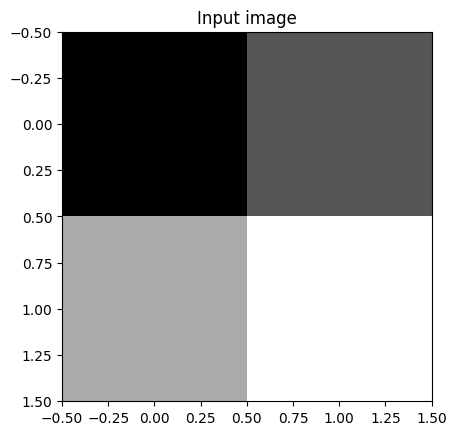

In [19]:
input_vector, input_angles = prepareInput(n=4, angle_range=(0, np.pi/2))

# Setup basic circuit:
frqi_circuit = QuantumCircuit()

coord_q_num = int(np.ceil(math.log(len(input_angles), 2)))      # no. of qubits to store coordinates

q = QuantumRegister(1,'q')                          # gray value
Q = QuantumRegister(coord_q_num, 'Q')               # coords
c = ClassicalRegister(Q.size+q.size, "c")           # measurement

frqi_circuit.add_register(q, Q, c)

# Apply 2n Hadamard gates to all positional qubits
frqi_circuit.id(q)
frqi_circuit.h(Q)

# list of positional qubits to control rotations
controls_ = []
for i in Q:
    controls_.append(i)

# Iteratively apply controlled rotation to color qubit based on positional qubits
for i, theta in enumerate(input_angles):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    # apply NOT gates appropriately so that only the concerned qubits control the rotation
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            frqi_circuit.x(Q[k])
            
    frqi_circuit.barrier()

    # multi-controlled rotation
    frqi_circuit.mcry(theta= 2*theta, q_controls=controls_, q_target=q[0])

    frqi_circuit.barrier()
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            frqi_circuit.x(Q[k])


frqi_circuit.barrier()

display(frqi_circuit.draw())
print(f"Depth: {frqi_circuit.depth()}, Width: {frqi_circuit.num_qubits}")


<IPython.core.display.Latex object>

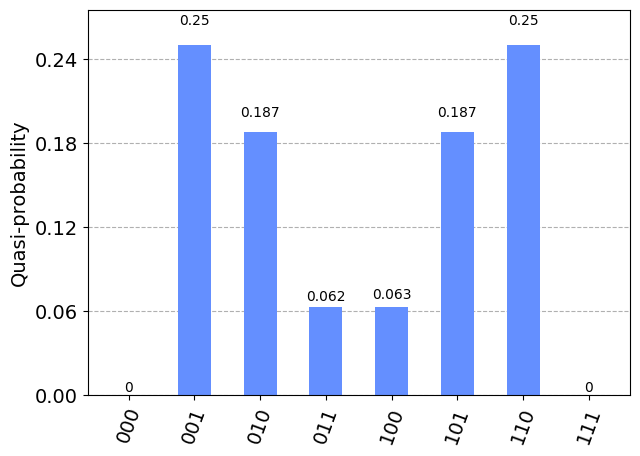

In [20]:
display(Statevector(frqi_circuit).draw('latex'))

plot_distribution(Statevector(frqi_circuit).probabilities_dict())

In [21]:
# Invert only the color pixel to invert all pixels
frqi_circuit.x(frqi_circuit.qregs[0])

ideal_distribution = Statevector.from_instruction(frqi_circuit).probabilities_dict()

frqi_circuit.barrier()

frqi_circuit.measure(list(reversed(range(frqi_circuit.num_qubits))), list(range(frqi_circuit.cregs[0].size)))

Elapsed Time: 0.0408s
Counts: {'110': 3733, '001': 3767, '000': 5027, '111': 4998, '101': 1260, '010': 1215}


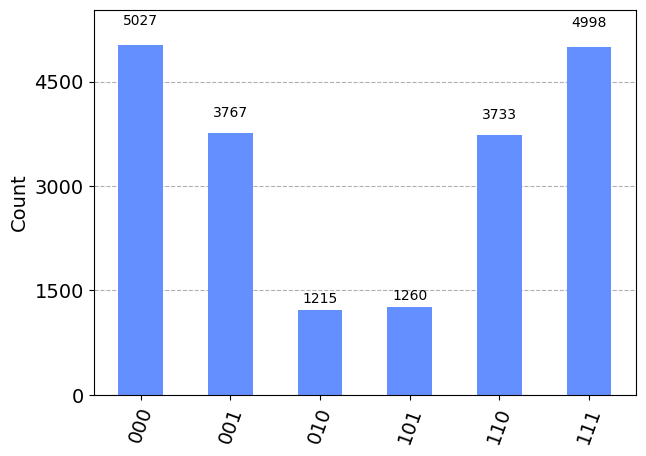

In [36]:
# Transpile and run simulation
transpiled_circuit = transpile(frqi_circuit, backend=backend)
job = backend.run(transpiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()


print(f"Elapsed Time: {'%.4f' % result.time_taken}s\nCounts: {counts}")
display(plot_histogram(counts))

For decoding, we need the gray value for every pixel.

$$
\upsilon = \arccos \left(\sqrt{\frac{P(j||0\rangle)}{P(j||0\rangle) + P(j||1\rangle)}}\right)
$$
where,  
$P(j||0\rangle)$ is the conditional probability of observing a state $j$ given that the gray value of the qubit is in state $|0\rangle$,  
Similarly, $P(j||1\rangle)$ is to probability of observing a state $j$ given that the gray value of the qubit is in state $|1\rangle$.  

This value is in radians and must be interpolated back from (0, $\pi/2$) to (0, 255).

In our case, the first qubit is associated with the gray value and the other qubits store the coordinates of that pixel.
1. For each pixel, we will iterate over every output state and check the coordinates of the state. If these coordinates match with the selected pixel, we will store the value.
2. We will iterate over the color values for that pixel, and calculate the total count, when that pixel had value '0'.
3. Use the above formula to get the exact value.
4. Interpolate back in range (0, 255).

In [24]:
# RECONSTRUCT
frqi_reconstruct = []

for i in range(len(input_vector)):
    color_list = []                         # stores the values 

    # step 1
    for key, count in counts.items():
        int_coord = int(key[1:], 2)         # all qubits but 1st will store coordinates
        
        # if coordinates match with pixel in focus, store the gray value and count
        if int_coord == i:
            color_list.append((key[0], count))        

    # step 2
    zero_count = 0                          # total count for gray value = 0
    for gvalue, count in color_list:
        if not int(gvalue):                 # if gvalue == 0, get total for P(j||0>)
            zero_count = zero_count + count

    # step 3
    try:
        gvalue = np.arccos((zero_count/sum(n for _, n in color_list))**(1/2))
        frqi_reconstruct.append(gvalue)

    except ZeroDivisionError:
        print("\tZeroDivisionError")

# step 4 (readout is reversed as we used 1st qubit for gray value instead of the last qubit)
frqi_reconstruct = list(reversed(np.interp(frqi_reconstruct, (0, np.pi/2), (0, 255)).astype(int)))
print(f"\nOriginal values: {input_vector}\nReconstructed Inverted values: {frqi_reconstruct}")


Original values: [  0  85 170 255]
Reconstructed Inverted values: [255, 170, 84, 0]


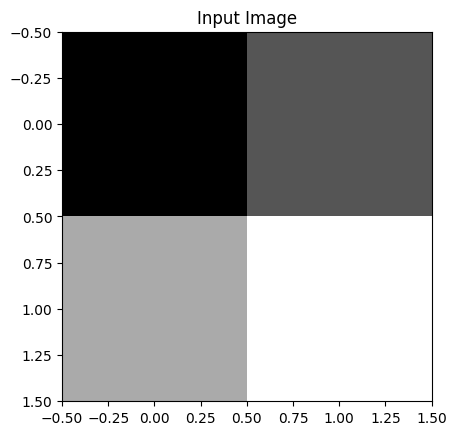

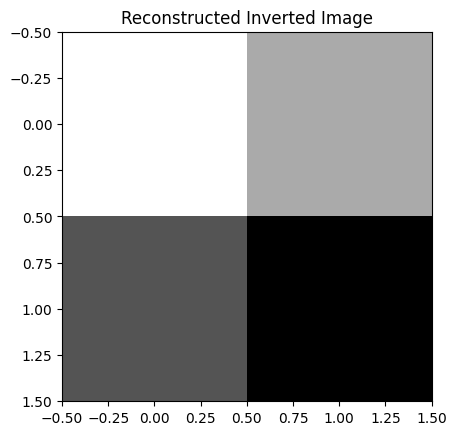

In [25]:
plt.imshow(np.reshape(input_vector, (int(math.sqrt(n)), int(math.sqrt(n)))), cmap = 'gray')
plt.title('Input Image')
plt.show()
plt.imshow(np.reshape(frqi_reconstruct, (int(math.sqrt(n)), int(math.sqrt(n)))), cmap = 'gray')
plt.title('Reconstructed Inverted Image')
plt.show()

$\rightarrow$ Accuracy: mean of absolute difference between output and expected value

In [26]:
ql_accuracy = statistics.fmean([1 - round(abs(ql_reconstruct[i] - (255 - input_vector[i]))/max((255 - input_vector[i]), ql_reconstruct[i]),4) if (255-input_vector[i]) != ql_reconstruct[i] else 1 for i in range(n)])
print(f"Qubit Lattice: {'%.3F' % ql_accuracy}")

ph_accuracy = statistics.fmean([1 - round(abs(ph_reconstruct[i] - (255 - input_vector[i]))/max((255 - input_vector[i]), ph_reconstruct[i]),4) if (255-input_vector[i]) != ph_reconstruct[i] else 1 for i in range(n)])
print(f"Phase Encoding: {'%.3F' % ph_accuracy}")

frqi_accuracy = statistics.fmean([1 - round(abs(frqi_reconstruct[i] - (255 - input_vector[i]))/max((255 - input_vector[i]), frqi_reconstruct[i]),4) if (255-input_vector[i]) != frqi_reconstruct[i] else 1 for i in range(n)])
print(f"FRQI: {'%.3F' % frqi_accuracy}")


Qubit Lattice: 0.997
Phase Encoding: 0.996
FRQI: 0.997
